In [284]:
#IMPORTING LIBRARIES 
import math
import numpy as np
import pandas as pd 
import pandas_datareader
import matplotlib.pyplot as pyplot

#A sequential model takes into account the order of things happening and is linear, it is also fairly simple to use.
from keras.models import Sequential

#Dense layer is the regular deeply connected neural network layer. Essentially a vanilla NN
#The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time, which helps prevent overfitting. Input data may have some of the unwanted data, usually called as Noise. Dropout will try to remove the noise data and thus prevent the model from over-fitting.
#LSTM is a Recurrent neural network that helps in sequential data (Data that needs to preserve order) and also helps fight the forgetting problem in vanilla RNN 
from keras.layers import LSTM,Dropout,Dense

#Transforms any actual range into a range of 0 to 1 so it is easier to work with, essentially the Sigmoid function / ReLU
from sklearn.preprocessing import MinMaxScaler

In [285]:
#IMPORTING DATA
df = pandas_datareader.DataReader('AAPL',data_source='yahoo', start= "2012-01-01", end="2019-12-31" )
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732143,14.607143,14.621429,14.686786,302220800.0,12.575914
2012-01-04,14.810000,14.617143,14.642857,14.765714,260022000.0,12.643497
2012-01-05,14.948214,14.738214,14.819643,14.929643,271269600.0,12.783867
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,12.917509
2012-01-09,15.276786,15.048214,15.196429,15.061786,394024400.0,12.897017
...,...,...,...,...,...,...
2019-12-24,71.222504,70.730003,71.172501,71.067497,48478800.0,69.938187
2019-12-26,72.495003,71.175003,71.205002,72.477501,93121200.0,71.325806
2019-12-27,73.492500,72.029999,72.779999,72.449997,146266000.0,71.298729


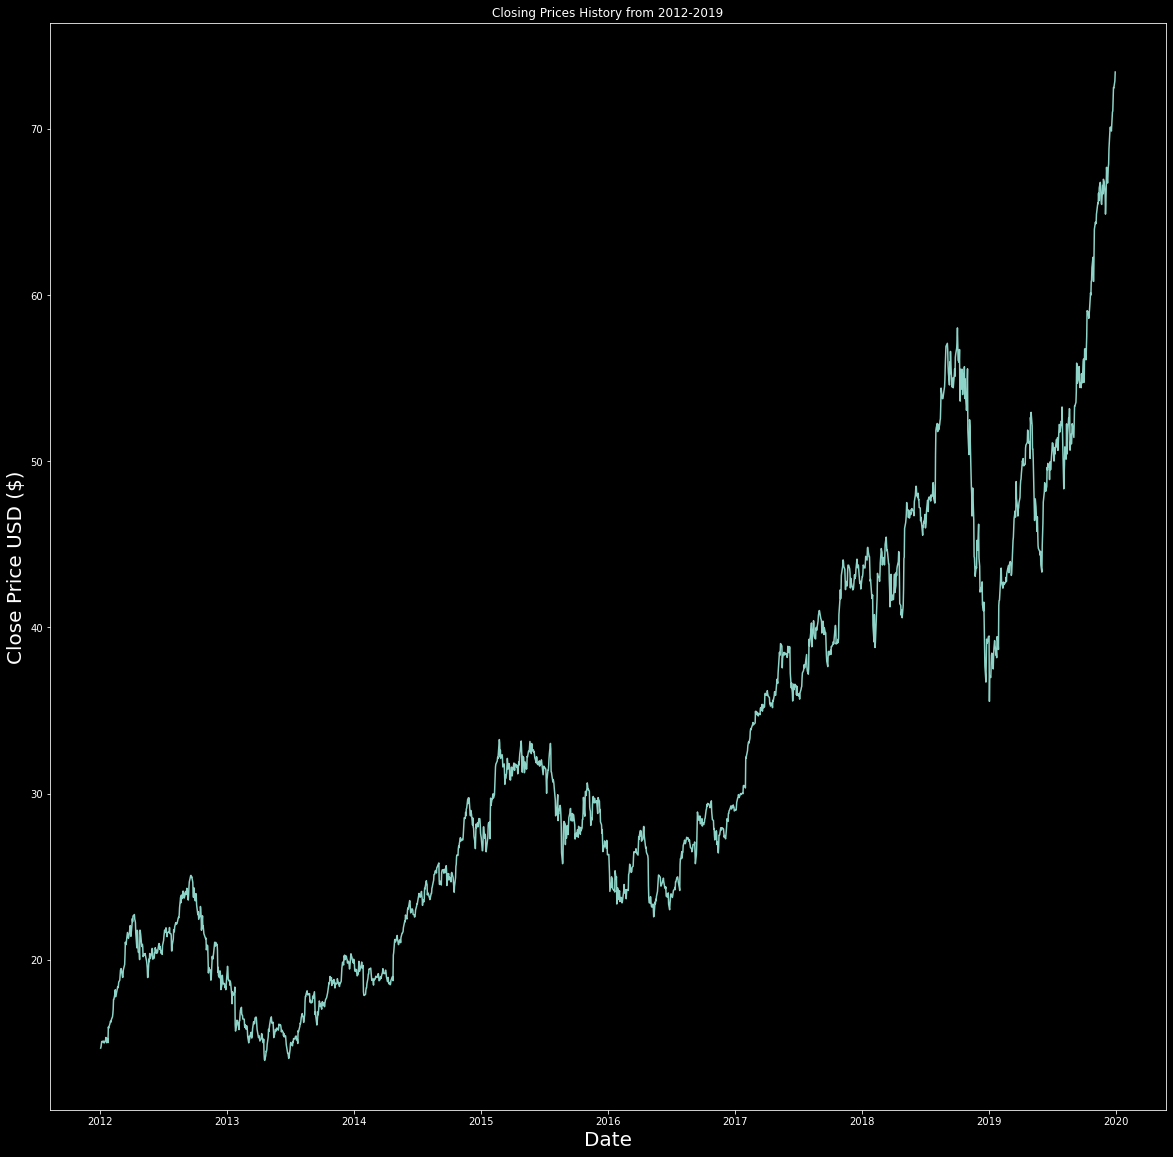

In [286]:
#VISUALISING CLOSING PRICES

#using my prefered styling for our graphs
pyplot.style.use('dark_background')
#Plotting the graph
pyplot.figure(figsize=(20,20))
pyplot.plot(df['Close'])
pyplot.title("Closing Prices History from 2012-2019")
pyplot.xlabel('Date', fontsize=20)
pyplot.ylabel('Close Price USD ($)', fontsize=20)
pyplot.show()

In [287]:
data = df.filter(['Close'])
#convert data frame to be numpy compatible 
dataset = data.values

#The rest is used to test 
train_len = math.ceil(len(dataset) * 0.8)

In [288]:
#Scaling the data and Creating training data sets 
#Converting the data from arrays of hundreds to arrays of 0 to 1s so we can work with them efficiently 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
#Creating the training data set 
train_data = scaled_data[0:train_len, :]

#x is the independant variable and y is dependant
x_train,y_train=[],[]

for i in range(60,len(train_data)):
    #We are leaving out some of the data set to test our model later
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
    
#Converting to numpy arrays / tensors to be used in models
x_train,y_train=np.array(x_train),np.array(y_train)
#We Reshape the model as LSTM requires a 3d shape so we just insert 1 to the 3rd dimension
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

In [274]:
#Build the LSTM model 
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (x_train.shape[1],1)))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

#Compilig the Model 
#A loss / cost function tells the computer how wrong it was from the actual result and a optimizer acts as a catalyst
model.compile(loss='mean_squared_error',optimizer='adam')

#Training the model
model.fit(x_train,y_train,batch_size=1,epochs=1)
#batch_size = how many batches at a time 
#epochs = how many times to run this program

1550/1550 [==============================] - 19s 11ms/step - loss: 5.8474e-04


In [289]:
#Creating Testing Data
test_data = scaled_data[train_len - 60: , :]
#Create data sets 
test_set = []
actual_values = dataset[train_len:,:]

#Using Rest of the dataframe
for i in range(60,len(test_data)):
    test_set.append(test_data[i-60:i,0])
    
#Converting test_set to numpy array and reshaping it
test_set = np.array(test_set)
test_set = np.reshape(test_set,(test_set.shape[0],test_set.shape[1],1))

In [290]:
#Get predicted prices
predicted_closing_price = model.predict(test_set)
predicted_closing_price = scaler.inverse_transform(predicted_closing_price)

In [319]:
#Getting standard deviation / RMSE (Root Mean Squared Error) it is a way to calculate the accuracy of our model
rmse =np.sqrt(np.mean(((predicted_closing_price- actual_values)**2)))
rmse = np.sqrt(np.mean(np.power((np.array(actual_values)-np.array(predicted_closing_price)),2)))
rmse = np.sqrt(((predicted_closing_price - actual_values) ** 2).mean())
rmse =  round(rmse,2)

/tmp/ipykernel_196917/3696592377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predicted_closing_price


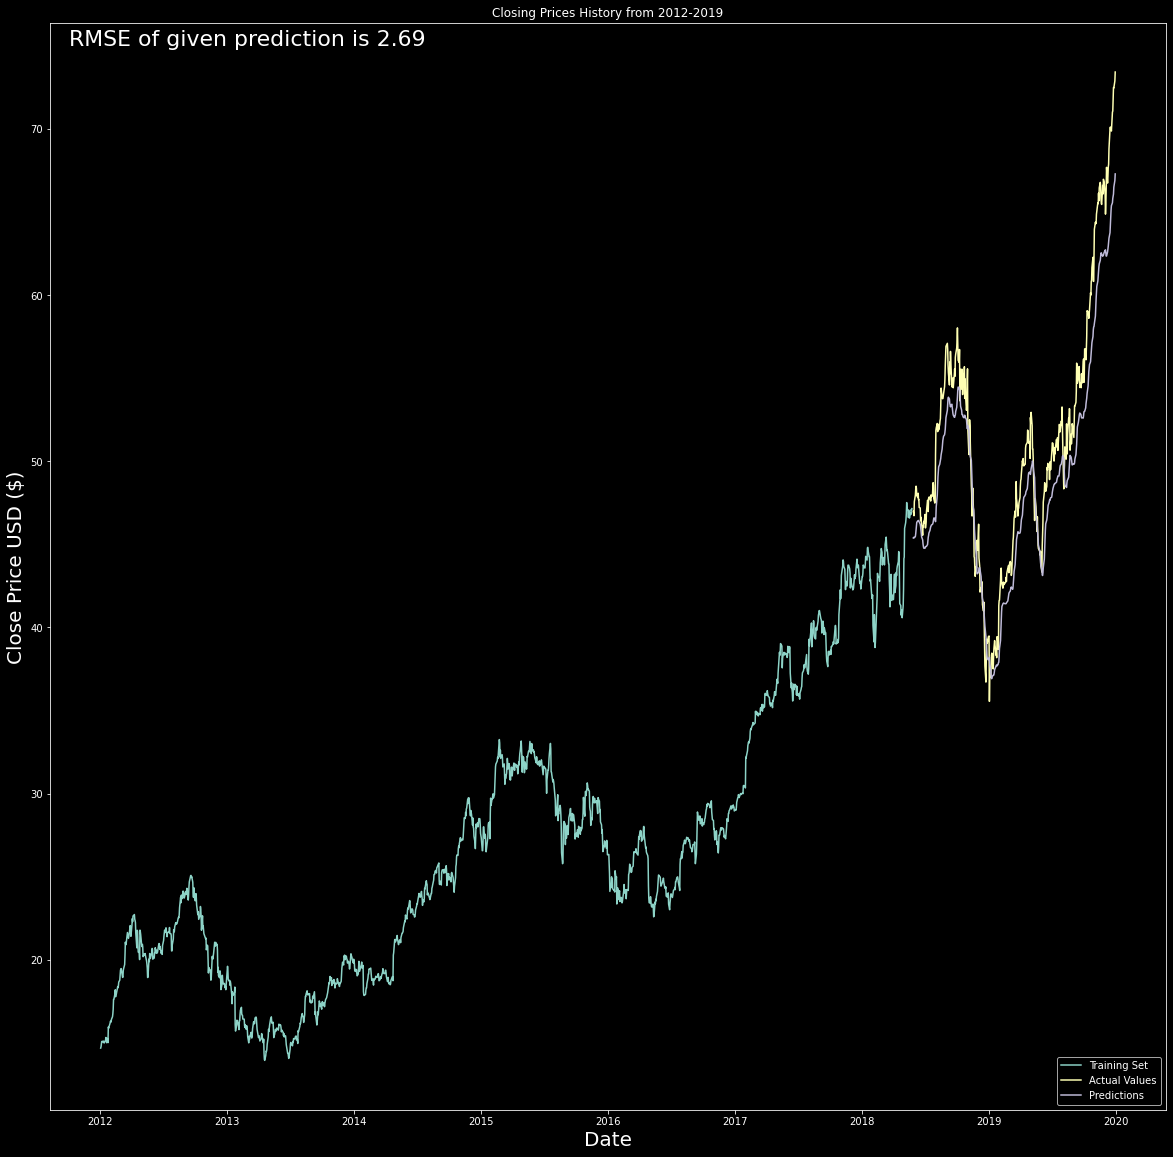

In [321]:
#Plot the data 
train = data[:train_len]
valid = data[train_len:]
valid['Predictions'] = predicted_closing_price
#Visualisation
pyplot.figure(figsize=(20,20))
pyplot.title("Closing Prices History from 2012-2019")
pyplot.xlabel('Date', fontsize=20)
pyplot.ylabel('Close Price USD ($)', fontsize=20)
pyplot.plot(train['Close'])
pyplot.plot(valid[['Close','Predictions']])
pyplot.legend(['Training Set','Actual Values','Predictions'],loc="lower right")
pyplot.text(15250,75,f'RMSE of given prediction is {rmse}', fontsize = 22)
pyplot.show()

print()